# Street View House Number

**Objetivo**: Reconocer los números en el exterior de las casas.

Data set: https://www.kaggle.com/datasets/stanfordu/street-view-house-numbers

In [ ]:

# Importamos las bibliotecas que usaremos en nuestro modelo
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation, Conv2D, MaxPooling2D 
from tensorflow.keras import backend as K
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import SVG
import scipy.io as sio
from skimage import io
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [ ]:
# Instalamos la biblioteca de Kaggle para poder descargar el dataset
! pip install -q kaggle

In [ ]:
# Importamos el archivo kaggle.json para poder descargar el dataset|
from google.colab import files
files.upload()
# Saving kaggle.json to kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargamos el dataset SHVN de Kaggle
! kaggle datasets download -d stanfordu/street-view-house-numbers

# Visualización de los datos a trabajar

In [225]:
# Definimos las rutas de las carpetas de las imagenes 
data_entrenamiento = 'C:/Users/pepe2/Documents/Escuela/train1'
imagenes = os.listdir('C:/Users/pepe2/Documents/Escuela/train1/train2')
print(imagenes)

['.Rhistory', '1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png', '1007.png', '1008.png', '1009.png', '101.png', '1010.png', '1011.png', '1012.png', '1013.png', '1014.png', '1015.png', '1016.png', '1017.png', '1018.png', '1019.png', '102.png', '1020.png', '1021.png', '1022.png', '1023.png', '1024.png', '1025.png', '1026.png', '1027.png', '1028.png', '1029.png', '103.png', '1030.png', '1031.png', '1032.png', '1033.png', '1034.png', '1035.png', '1036.png', '1037.png', '1038.png', '1039.png', '104.png', '1040.png', '1041.png', '1042.png', '1043.png', '1044.png', '1045.png', '1046.png', '1047.png', '1048.png', '1049.png', '105.png', '1050.png', '1051.png', '1052.png', '1053.png', '1054.png', '1055.png', '1056.png', '1057.png', '1058.png', '1059.png', '106.png', '1060.png', '1061.png', '1062.png', '1063.png', '1064.png', '1065.png', '1066.png', '1067.png', '1068.png', '1069.png', '107.png', '1070.png', '1071.png', '1072.png', '10

In [224]:
# Ahora creamos un arreglo de cada una de las imagenes
imagenes_data = []
for i in range(1,5000):
    imagenes_data.append(io.imread(data_entrenamiento+'/train2/'+imagenes[i])/255.0)

imagenes_data

[array([[[0.16078431, 0.37647059, 0.21960784],
         [0.16078431, 0.37647059, 0.22352941],
         [0.16862745, 0.37254902, 0.23137255],
         ...,
         [0.14509804, 0.39215686, 0.20784314],
         [0.14509804, 0.39215686, 0.20784314],
         [0.14509804, 0.39215686, 0.21568627]],
 
        [[0.16470588, 0.38431373, 0.23137255],
         [0.16470588, 0.38431373, 0.23137255],
         [0.16862745, 0.38039216, 0.23921569],
         ...,
         [0.15294118, 0.4       , 0.21568627],
         [0.15294118, 0.4       , 0.21568627],
         [0.15294118, 0.4       , 0.22352941]],
 
        [[0.16862745, 0.39607843, 0.23921569],
         [0.16862745, 0.39607843, 0.23921569],
         [0.16862745, 0.38823529, 0.24313725],
         ...,
         [0.15686275, 0.40392157, 0.22745098],
         [0.15686275, 0.40392157, 0.22745098],
         [0.15686275, 0.40392157, 0.22745098]],
 
        ...,
 
        [[0.19607843, 0.47843137, 0.32156863],
         [0.19607843, 0.47843137, 0.32156

In [ ]:
from pymatreader import read_mat
data = read_mat('C:/Users/pepe2/Documents/Escuela/train_digitStruct.mat')
# data.keys()
type(data)

In [227]:
df = pd.DataFrame(data['digitStruct']).head(5000)

# Ahora dividimos los datos de la columna bbox en columnas separadas
df1 = pd.concat([df.drop(['bbox'], axis=1), df['bbox'].apply(pd.Series)], axis=1)
df1 = df1.drop(['height', 'left', 'top', 'width','name'], axis=1)
print(df1)

                label
0          [1.0, 9.0]
1          [2.0, 3.0]
2          [2.0, 5.0]
3          [9.0, 3.0]
4          [3.0, 1.0]
...               ...
4995              1.0
4996       [1.0, 6.0]
4997              4.0
4998       [1.0, 7.0]
4999  [2.0, 4.0, 7.0]

[5000 rows x 1 columns]


In [228]:
#Guardamos el dataframe en un archivo csv
df1.to_csv('C:/Users/pepe2/Documents/Escuela/train_digitStruct.csv')

**Mostramos como están interconectados los datos como una red**

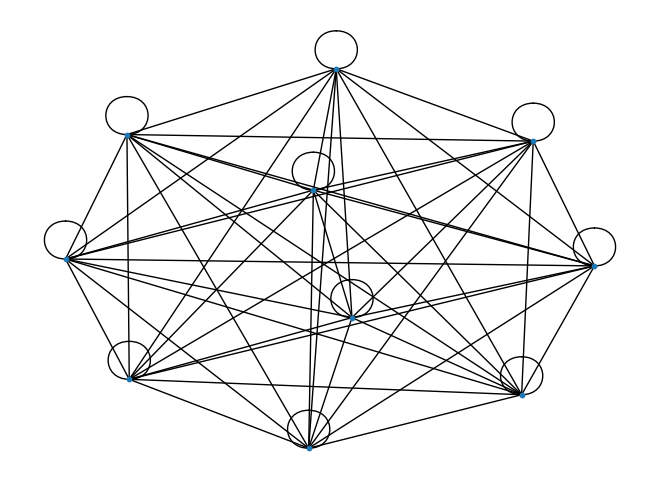

In [237]:
import networkx as nx

#Agregamos los enlaces a un grafo a partir de los datos de la columna 'label' del dataframe
G = nx.Graph()
for i in range(1,5000):
    if type(df1['label'][i]) == list and len(df1['label'][i]) == 2:
        G.add_edge(df1['label'][i][0],df1['label'][i][1])    

nx.draw(G, node_size=10)



# Red Neuronal

In [208]:
# Definimos las rutas de las carpetas de las imagenes de entrenamiento y prueba
data_entrenamiento = 'C:/Users/pepe2/Documents/Escuela/train1'
data_validacion = 'C:/Users/pepe2/Documents/Escuela/test1'

# Definimos los parametros iniciales de nuestro modelo
batch_size = 32
pasos = 10
validation_steps = 300
filtrosConv1 = 32
filtrosConv2 = 64
tamano_filtro1 = (3, 3)
tamano_filtro2 = (2, 2)
tamano_pool = (2, 2)
clases = 10
lr = 0.0005
img_height = 100
img_width = 100

# Preparamos nuestras imagenes para el entrenamiento y validacion
entrenamiento_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip = True,
)

validacion_datagen = ImageDataGenerator(
    rescale=1. / 255
)


# Definimos las imagenes de entrenamiento y validacion
imagen_entrenamiento = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',

)

imagen_validacion = validacion_datagen.flow_from_directory(
    data_validacion,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)





Found 5000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


# Modelo 1

In [222]:
# Definimos nuestro primer modelo de red neuronal convolucional con Optimizador Adam y learning rate de 0.0005
x = Sequential()

x.add(Conv2D(filtrosConv1, tamano_filtro1, padding ="same", input_shape = (img_height,img_width,3), activation = 'relu'))
x.add(MaxPooling2D(pool_size = tamano_pool))
x.add(Conv2D(filtrosConv2, tamano_filtro2, padding ="same", activation = 'relu'))
x.add(MaxPooling2D(pool_size = tamano_pool))
x.add(Flatten())
x.add(Dense(256, activation = 'relu'))
x.add(Dense(clases, activation = 'softmax'))

x.summary()

x.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(learning_rate=lr),
            metrics=['accuracy'])

history = x.fit_generator(imagen_entrenamiento, steps_per_epoch=pasos, epochs=20, validation_data=imagen_validacion, validation_steps=validation_steps)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 40000)             0         
                                                                 
 dense_129 (Dense)           (None, 256)             

C:\Users\pepe2\AppData\Local\Temp\ipykernel_18756\2052142099.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = x.fit_generator(imagen_entrenamiento, steps_per_epoch=pasos, epochs=20, validation_data=imagen_validacion, validation_steps=validation_steps)


10/10 [==============================] - ETA: 0s - loss: 91.9338 - accuracy: 0.9156WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 300 batches). You may need to use the repeat() function when building your dataset.


10/10 [==============================] - 8s 675ms/step - loss: 91.9338 - accuracy: 0.9156 - val_loss: 238.3146 - val_accuracy: 1.0000
Epoch 2/20
10/10 [==============================] - 3s 323ms/step - loss: 510.7240 - accuracy: 0.3313
Epoch 3/20
10/10 [==============================] - 3s 313ms/step - loss: 1773.5587 - accuracy: 0.5338
Epoch 4/20
10/10 [==============================] - 3s 315ms/step - loss: 4131.4233 - accuracy: 0.4469
Epoch 5/20
10/10 [==============================] - 3s 310ms/step - loss: 9403.8730 - accuracy: 0.2937
Epoch 6/20
10/10 [==============================] - 3s 305ms/step - loss: 17837.3945 - accuracy: 0.2162
Epoch 7/20
10/10 [==============================] - 3s 319ms/step - loss: 31097.7070 - accuracy: 0.2937
Epoch 8/20
10/10 [==============================] - 3s 309ms/step - loss: 51577.4609 - accuracy: 0.2000
Epoch 9/20
10/10 [==============================] - 3s 304ms/step - loss: 80760.7500 - accuracy: 0.2000
Epoch 10/20
10/10 [====================

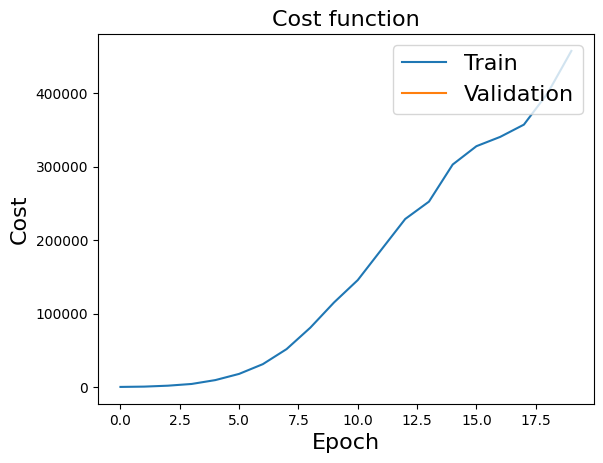

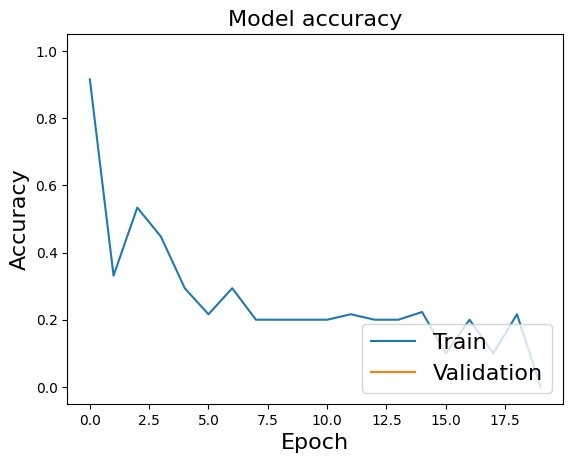

In [223]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cost function', size=16)
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 16})
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', prop={'size': 16})
plt.show()

# Modelo 2

In [220]:
# Definimos nuestro segundo modelo de red neuronal convolucional con Optimizador SGD y learning rate de 0.0005
x = Sequential()

x.add(Conv2D(filtrosConv1, tamano_filtro1, padding ="same", input_shape = (img_height,img_width,3), activation = 'relu'))
x.add(MaxPooling2D(pool_size = tamano_pool))
x.add(Conv2D(filtrosConv2, tamano_filtro2, padding ="same", activation = 'relu'))
x.add(MaxPooling2D(pool_size = tamano_pool))
x.add(Flatten())
x.add(Dense(256, activation = 'relu'))
x.add(Dense(clases, activation = 'softmax'))

x.summary()

x.compile(loss='categorical_crossentropy',
            optimizer=optimizers.SGD(learning_rate=lr),
            metrics=['accuracy'])

history = x.fit_generator(imagen_entrenamiento, steps_per_epoch=pasos, epochs=20, validation_data=imagen_validacion, validation_steps=validation_steps)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 40000)             0         
                                                                 
 dense_127 (Dense)           (None, 256)             

C:\Users\pepe2\AppData\Local\Temp\ipykernel_18756\1084270431.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = x.fit_generator(imagen_entrenamiento, steps_per_epoch=pasos, epochs=20, validation_data=imagen_validacion, validation_steps=validation_steps)


Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 23.3239 - accuracy: 0.7875WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 300 batches). You may need to use the repeat() function when building your dataset.


10/10 [==============================] - 6s 594ms/step - loss: 23.3239 - accuracy: 0.7875 - val_loss: 24.2804 - val_accuracy: 0.9660
Epoch 2/20
10/10 [==============================] - 3s 255ms/step - loss: 30.5134 - accuracy: 0.9906
Epoch 3/20
10/10 [==============================] - 3s 260ms/step - loss: 974584853561344.0000 - accuracy: 0.3344
Epoch 4/20
10/10 [==============================] - 3s 266ms/step - loss: nan - accuracy: 1.0000
Epoch 5/20
10/10 [==============================] - 3s 263ms/step - loss: nan - accuracy: 1.0000
Epoch 6/20
10/10 [==============================] - 3s 266ms/step - loss: nan - accuracy: 1.0000
Epoch 7/20
10/10 [==============================] - 3s 256ms/step - loss: nan - accuracy: 1.0000
Epoch 8/20
10/10 [==============================] - 3s 274ms/step - loss: nan - accuracy: 1.0000
Epoch 9/20
10/10 [==============================] - 2s 237ms/step - loss: nan - accuracy: 1.0000
Epoch 10/20
10/10 [==============================] - 2s 240ms/step - l

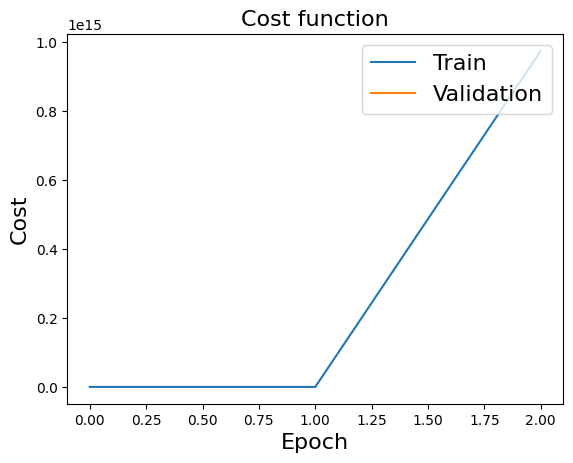

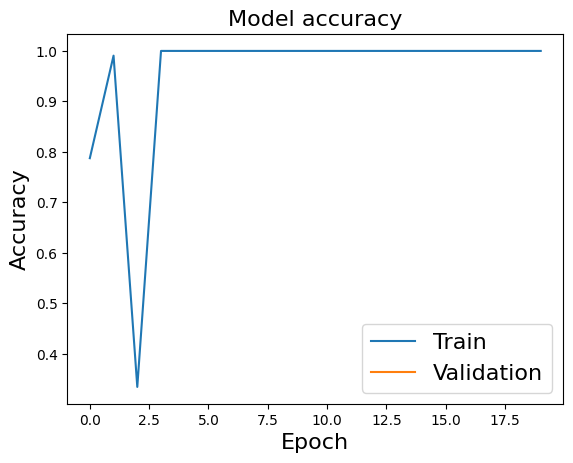

In [221]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cost function', size=16)
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 16})
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', prop={'size': 16})
plt.show()

# Modelo 3

In [217]:
# Definimos nuestro tercer modelo de red neuronal convolucional con Optimizador Adam y learning rate de 0.1
x = Sequential()

x.add(Conv2D(filtrosConv1, tamano_filtro1, padding ="same", input_shape = (img_height,img_width,3), activation = 'relu'))
x.add(MaxPooling2D(pool_size = tamano_pool))
x.add(Conv2D(filtrosConv2, tamano_filtro2, padding ="same", activation = 'relu'))
x.add(MaxPooling2D(pool_size = tamano_pool))
x.add(Flatten())
x.add(Dense(256, activation = 'relu'))
x.add(Dense(clases, activation = 'softmax'))

x.summary()

x.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(learning_rate=0.1),
            metrics=['accuracy'])

history = x.fit_generator(imagen_entrenamiento, steps_per_epoch=pasos, epochs=20, validation_data=imagen_validacion, validation_steps=validation_steps)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 50, 50, 64)        8256      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 40000)             0         
                                                                 
 dense_125 (Dense)           (None, 256)             

C:\Users\pepe2\AppData\Local\Temp\ipykernel_18756\1961522940.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = x.fit_generator(imagen_entrenamiento, steps_per_epoch=pasos, epochs=20, validation_data=imagen_validacion, validation_steps=validation_steps)


Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 34919688.0000 - accuracy: 0.1000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 300 batches). You may need to use the repeat() function when building your dataset.


10/10 [==============================] - 8s 678ms/step - loss: 34919688.0000 - accuracy: 0.1000 - val_loss: 227301280.0000 - val_accuracy: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 3s 330ms/step - loss: 772811520.0000 - accuracy: 0.1000
Epoch 3/20
10/10 [==============================] - 4s 362ms/step - loss: 5567824384.0000 - accuracy: 0.1000
Epoch 4/20
10/10 [==============================] - 3s 338ms/step - loss: 23663626240.0000 - accuracy: 0.1000
Epoch 5/20
10/10 [==============================] - 3s 330ms/step - loss: 56618045440.0000 - accuracy: 0.1000
Epoch 6/20
10/10 [==============================] - 3s 326ms/step - loss: 159322537984.0000 - accuracy: 0.1081
Epoch 7/20
10/10 [==============================] - 3s 315ms/step - loss: 399540846592.0000 - accuracy: 0.1000
Epoch 8/20
10/10 [==============================] - 3s 303ms/step - loss: 810148888576.0000 - accuracy: 0.1081
Epoch 9/20
10/10 [==============================] - 3s 319ms/step - loss: 108707

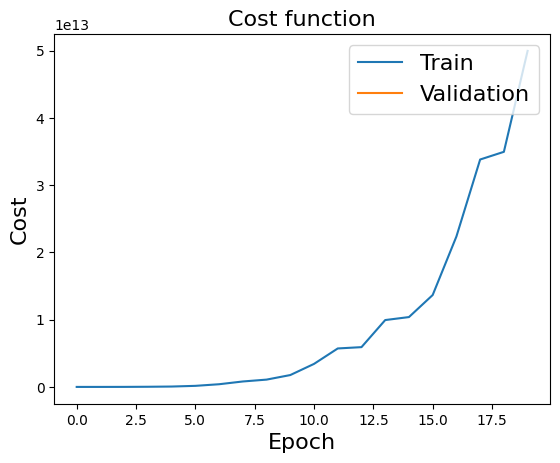

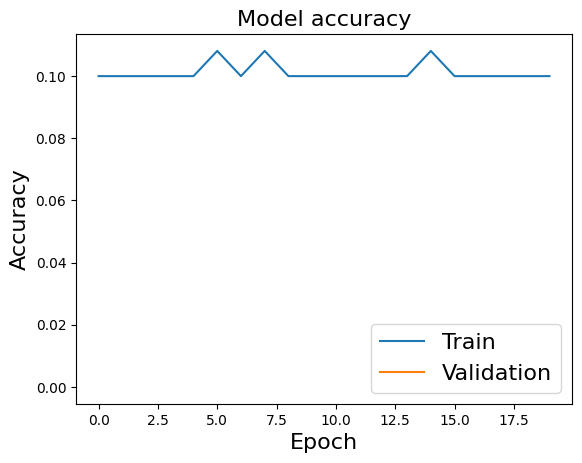

In [219]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cost function', size=16)
plt.ylabel('Cost', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='upper right', prop={'size': 16})
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Train', 'Validation'], loc='lower right', prop={'size': 16})
plt.show()

# Conclusión

Dada la complejidad del problema por la clasificación multiclase y multilabel, se propone utilizar modelos más robustos con ayuda de Pytorch (módulos dataloader) y un pre entrenamiento con los datos de MNIST. 

De igual manera, la cantidad de datos originales eran 60,000, por lo que el tiempo de compilación es extenuante por lo que se supone se necesita una mayor capacidad de cómputo.

Finalmente, es importante conocer el funcionamiento de los archivos de ".mat" para poder manejar adecuadamente el dataframe.